In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

In [23]:
# DATA LOADING
recipes_df = pd.read_csv("RAW_recipes.csv")
interactions_df = pd.read_csv("RAW_interactions.csv")

print(f"Recipes dataset: {recipes_df.shape[0]:,} recipes, {recipes_df.shape[1]} features")
print(f"Interactions dataset: {interactions_df.shape[0]:,} interactions, {interactions_df.shape[1]} features")

# Preview recipe structure
print("\nRecipe columns:", list(recipes_df.columns))
print("\nSample recipe entry:")
print(recipes_df.iloc[0])

Recipes dataset: 231,637 recipes, 12 features
Interactions dataset: 1,132,367 interactions, 5 features

Recipe columns: ['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients']

Sample recipe entry:
name                     arriba   baked winter squash mexican style
id                                                           137739
minutes                                                          55
contributor_id                                                47892
submitted                                                2005-09-16
tags              ['60-minutes-or-less', 'time-to-make', 'course...
nutrition                     [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]
n_steps                                                          11
steps             ['make a choice and proceed with recipe', 'dep...
description       autumn is my favorite time of year to cook! th...
ingredients       ['winter squash

In [24]:
# DATA MERGING

# Join recipes with user interactions
merged_data = recipes_df.merge(
    interactions_df,
    how="inner",
    left_on="id",
    right_on="recipe_id"
)

# Remove duplicate column after merge
if "recipe_id" in merged_data.columns:
    merged_data = merged_data.drop(columns=["recipe_id"])

print(f"Merged dataset size: {merged_data.shape[0]:,} rows, {merged_data.shape[1]} columns")

# Check for missing data
null_summary = merged_data.isnull().sum()
null_present = null_summary[null_summary > 0]
print("\nColumns with missing values:")
if len(null_present) > 0:
    for col, count in null_present.items():
        pct = (count / len(merged_data)) * 100
        print(f"  {col}: {count:,} ({pct:.2f}%)")
else:
    print("  None found")

Merged dataset size: 1,132,367 rows, 16 columns

Columns with missing values:
  name: 1 (0.00%)
  description: 23,510 (2.08%)
  review: 169 (0.01%)


In [25]:
# DATETIME PROCESSING

# Convert date strings to datetime objects
merged_data["submitted"] = pd.to_datetime(merged_data["submitted"], errors="coerce")
merged_data["date"] = pd.to_datetime(merged_data["date"], errors="coerce")

# Create derived temporal features
merged_data["recipe_year"] = merged_data["submitted"].dt.year
merged_data["recipe_month"] = merged_data["submitted"].dt.month
merged_data["review_year"] = merged_data["date"].dt.year
merged_data["review_month"] = merged_data["date"].dt.month

# Display date range
print(f"Recipe submissions span: {merged_data['submitted'].min()} to {merged_data['submitted'].max()}")
print(f"Reviews span: {merged_data['date'].min()} to {merged_data['date'].max()}")

Recipe submissions span: 1999-08-06 00:00:00 to 2018-12-04 00:00:00
Reviews span: 2000-01-25 00:00:00 to 2018-12-20 00:00:00


In [26]:
# NUTRITIONAL DATA EXTRACTION

# Nutrition column contains a list-like string: [cal, fat, sugar, sodium, protein, sat_fat, carbs]
nutrition_columns = ["calories", "total_fat", "sugar", "sodium", "protein", "saturated_fat", "carbohydrates"]

def parse_nutrition_string(nutrition_str):
    """Extract numerical values from nutrition string"""
    try:
        # Remove brackets and split by comma
        cleaned = str(nutrition_str).strip("[]")
        values = [float(v.strip()) for v in cleaned.split(",")]
        return values
    except:
        return [np.nan] * 7

# Apply parsing and create new columns
nutrition_values = merged_data["nutrition"].apply(parse_nutrition_string)
nutrition_df = pd.DataFrame(nutrition_values.tolist(), columns=nutrition_columns)

# Concatenate with main dataframe
merged_data = pd.concat([merged_data, nutrition_df], axis=1)

print("Nutritional features added:")
print(merged_data[nutrition_columns].describe().round(2))


Nutritional features added:
         calories   total_fat       sugar      sodium     protein  \
count  1132367.00  1132367.00  1132367.00  1132367.00  1132367.00   
mean       460.18       34.64       78.60       31.97       35.76   
std       1029.89       73.25      635.28      120.56       74.49   
min          0.00        0.00        0.00        0.00        0.00   
25%        176.40        9.00        9.00        6.00        7.00   
50%        312.70       20.00       24.00       16.00       18.00   
75%        512.70       40.00       67.00       35.00       53.00   
max     434360.20    17183.00   362729.00    29338.00     6552.00   

       saturated_fat  carbohydrates  
count     1132367.00     1132367.00  
mean           44.14          14.93  
std            94.84          65.70  
min             0.00           0.00  
25%             7.00           4.00  
50%            23.00           9.00  
75%            52.00          16.00  
max         10395.00       36098.00  


Unique recipes in dataset: 231,637

Cooking time statistics:
count    2.316370e+05
mean     9.398546e+03
std      4.461963e+06
min      0.000000e+00
25%      2.000000e+01
50%      4.000000e+01
75%      6.500000e+01
max      2.147484e+09
Name: minutes, dtype: float64


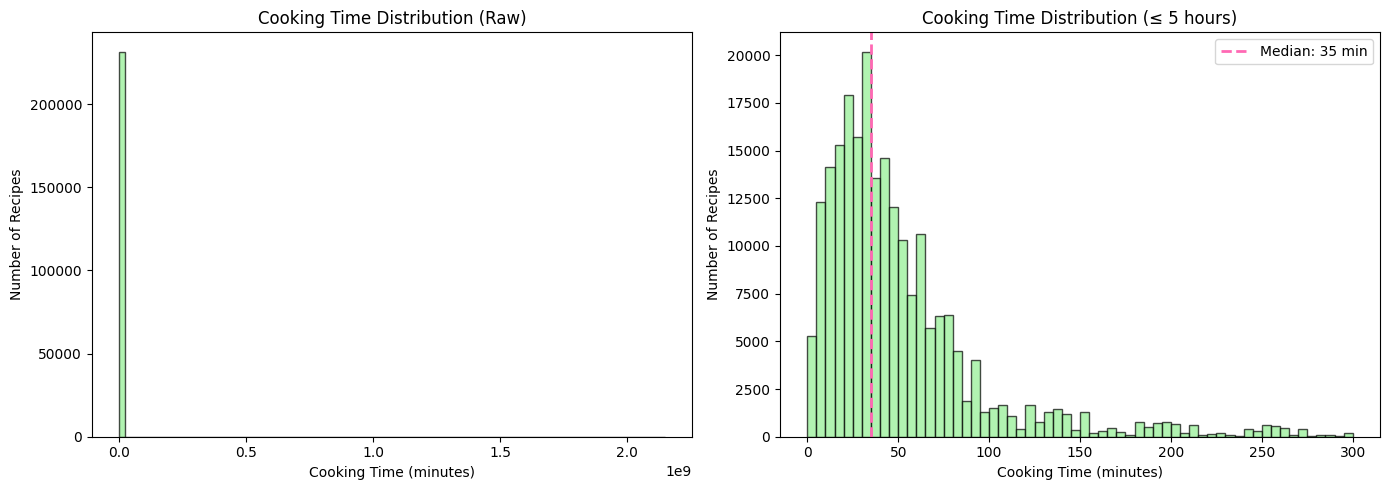

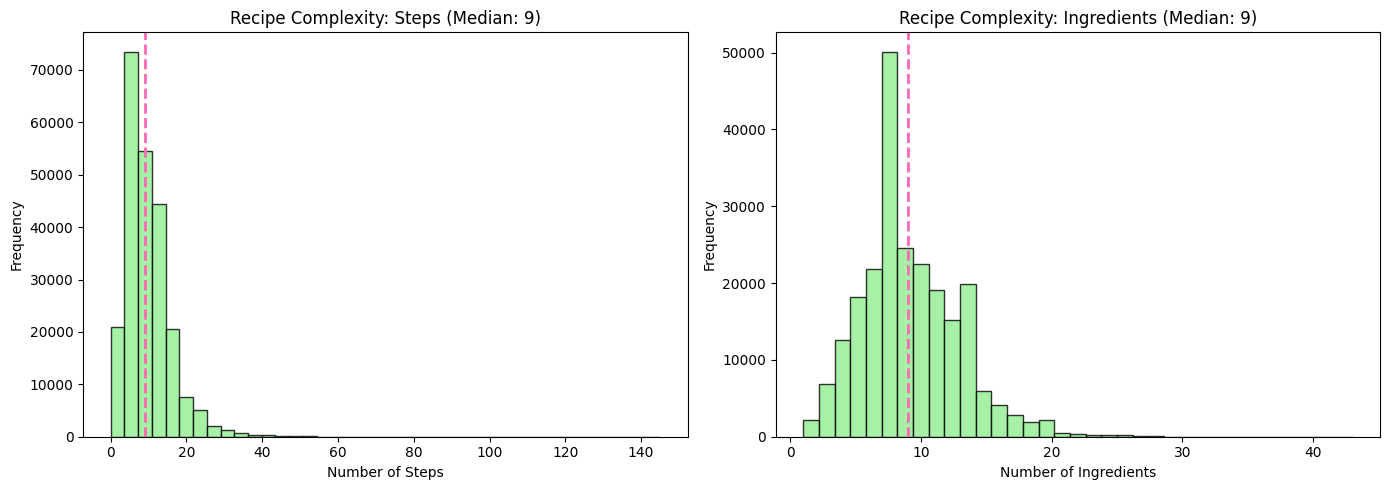

In [44]:
# 5. RECIPE CHARACTERISTICS ANALYSIS

# Get unique recipes for analysis (avoid counting duplicates from reviews)
unique_recipes = merged_data.drop_duplicates(subset=["id"])
print(f"Unique recipes in dataset: {len(unique_recipes):,}")

# --- Cooking Time Analysis ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw distribution
axes[0].hist(unique_recipes["minutes"], bins=100, color="lightgreen", edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Cooking Time (minutes)")
axes[0].set_ylabel("Number of Recipes")
axes[0].set_title("Cooking Time Distribution (Raw)")

# Identify and report outliers
time_stats = unique_recipes["minutes"].describe()
print("\nCooking time statistics:")
print(time_stats)

# Filtered distribution (remove extreme outliers for visualization)
reasonable_time = unique_recipes[unique_recipes["minutes"] <= 300]["minutes"]
axes[1].hist(reasonable_time, bins=60, color="lightgreen", edgecolor="black", alpha=0.7)
axes[1].axvline(reasonable_time.median(), color="hotpink", linestyle="--", linewidth=2, label=f"Median: {reasonable_time.median():.0f} min")
axes[1].set_xlabel("Cooking Time (minutes)")
axes[1].set_ylabel("Number of Recipes")
axes[1].set_title("Cooking Time Distribution (≤ 5 hours)")
axes[1].legend()

plt.tight_layout()
plt.show()

# --- Recipe Complexity ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Number of steps
axes[0].hist(unique_recipes["n_steps"], bins=40, color="lightgreen", edgecolor="black", alpha=0.8)
axes[0].axvline(unique_recipes["n_steps"].median(), color="hotpink", linestyle="--", linewidth=2)
axes[0].set_xlabel("Number of Steps")
axes[0].set_ylabel("Frequency")
axes[0].set_title(f"Recipe Complexity: Steps (Median: {unique_recipes['n_steps'].median():.0f})")

# Number of ingredients
axes[1].hist(unique_recipes["n_ingredients"], bins=35, color="lightgreen", edgecolor="black", alpha=0.8)
axes[1].axvline(unique_recipes["n_ingredients"].median(), color="hotpink", linestyle="--", linewidth=2)
axes[1].set_xlabel("Number of Ingredients")
axes[1].set_ylabel("Frequency")
axes[1].set_title(f"Recipe Complexity: Ingredients (Median: {unique_recipes['n_ingredients'].median():.0f})")

plt.tight_layout()
plt.show()

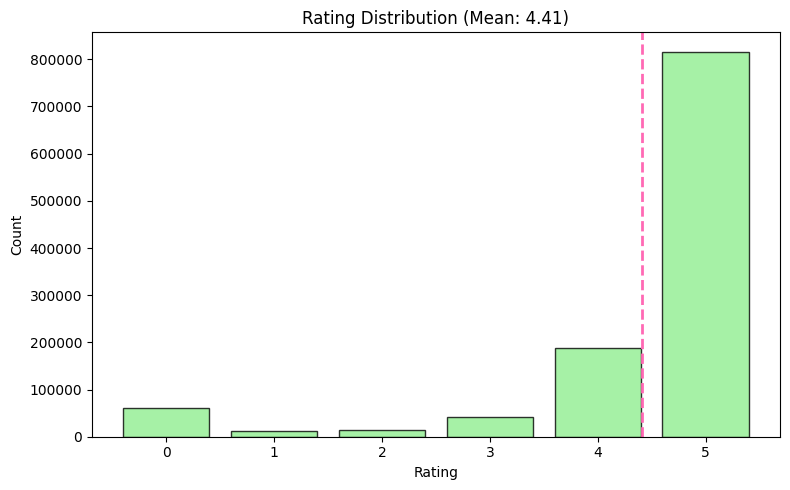

Rating statistics:
count    1.132367e+06
mean     4.411016e+00
std      1.264752e+00
min      0.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


In [41]:
# RATING ANALYSIS

# Rating distribution
fig, ax = plt.subplots(figsize=(8, 5))
rating_freq = merged_data["rating"].value_counts().sort_index()
bars = ax.bar(rating_freq.index, rating_freq.values, color="lightgreen", edgecolor="black", alpha=0.8)
ax.axvline(merged_data["rating"].mean(), color="hotpink", linestyle="--", linewidth=2)
ax.set_xlabel("Rating")
ax.set_ylabel("Count")
ax.set_title(f"Rating Distribution (Mean: {merged_data['rating'].mean():.2f})")
ax.set_xticks([0, 1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

print(f"Rating statistics:")
print(merged_data["rating"].describe())

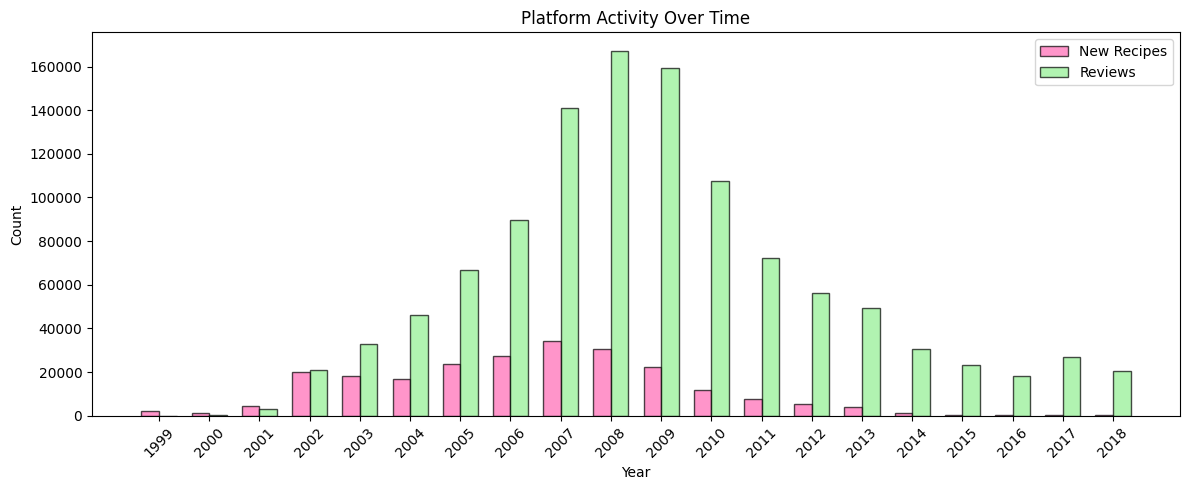

In [48]:
# TEMPORAL TRENDS

# Yearly activity
fig, ax = plt.subplots(figsize=(12, 5))

yearly_submissions = unique_recipes.groupby("recipe_year").size()
yearly_reviews = merged_data.groupby("review_year").size()

years = sorted(set(yearly_submissions.index.dropna()) | set(yearly_reviews.index.dropna()))
bar_width = 0.35
x_positions = np.arange(len(years))

ax.bar(x_positions - bar_width/2, [yearly_submissions.get(y, 0) for y in years], 
       bar_width, label="New Recipes", color="hotpink", edgecolor="black", alpha=0.7)
ax.bar(x_positions + bar_width/2, [yearly_reviews.get(y, 0) for y in years], 
       bar_width, label="Reviews", color="lightgreen", edgecolor="black", alpha=0.7)

ax.set_xticks(x_positions)
ax.set_xticklabels([int(y) if pd.notna(y) else "" for y in years], rotation=45)
ax.set_xlabel("Year")
ax.set_ylabel("Count")
ax.set_title("Platform Activity Over Time")
ax.legend()

plt.tight_layout()
plt.show()

Top 20 most common ingredients:
           ingredient  count
0                salt  85746
1              butter  54975
2               sugar  44535
3               onion  39065
4               water  34914
5                eggs  33761
6           olive oil  32822
7               flour  26266
8                milk  25786
9       garlic cloves  25748
10             pepper  22319
11        brown sugar  18655
12             garlic  18087
13  all-purpose flour  17659
14      baking powder  17504
15                egg  17304
16    salt and pepper  15415
17    parmesan cheese  14807
18        lemon juice  14233
19        baking soda  14099


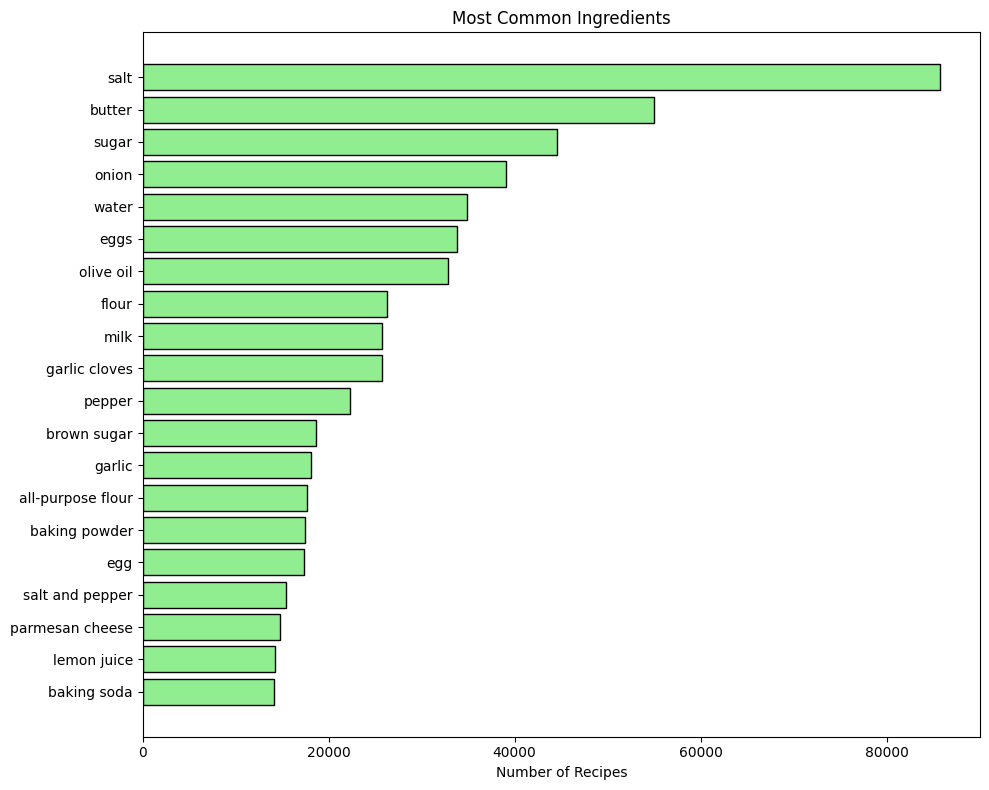

In [50]:
# INGREDIENT ANALYSIS (RELEVANT FOR SEARCH)

def extract_ingredients_list(ing_string):
    """Parse ingredient string into list"""
    try:
        cleaned = str(ing_string).replace("[", "").replace("]", "").replace("'", "")
        ingredients = [i.strip().lower() for i in cleaned.split(",")]
        return ingredients
    except:
        return []

# Extract all ingredients
all_ingredients = []
for ing_str in unique_recipes["ingredients"]:
    all_ingredients.extend(extract_ingredients_list(ing_str))

# Count frequency
ingredient_counts = Counter(all_ingredients)
top_ingredients = pd.DataFrame(
    ingredient_counts.most_common(20),
    columns=["ingredient", "count"]
)

print("Top 20 most common ingredients:")
print(top_ingredients)

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(top_ingredients["ingredient"][::-1], top_ingredients["count"][::-1], color="lightgreen", edgecolor="black")
ax.set_xlabel("Number of Recipes")
ax.set_title("Most Common Ingredients")

plt.tight_layout()
plt.show()

In [31]:
# TAG ANALYSIS (FOR SEMANTIC SEARCH)


def extract_tags_list(tag_string):
    """Parse tag string into list"""
    try:
        cleaned = str(tag_string).replace("[", "").replace("]", "").replace("'", "")
        tags = [t.strip().lower() for t in cleaned.split(",")]
        return tags
    except:
        return []

# Extract all tags
all_tags = []
for tag_str in unique_recipes["tags"]:
    all_tags.extend(extract_tags_list(tag_str))

# Count frequency
tag_counts = Counter(all_tags)
top_tags = pd.DataFrame(
    tag_counts.most_common(30),
    columns=["tag", "frequency"]
)

print("Top 30 most common tags:")
print(top_tags)

# These tags will be crucial for matching queries like "comfort food", "healthy", etc.
semantic_tags = ["comfort-food", "healthy", "quick", "easy", "romantic", "vegetarian", 
                 "low-carb", "dessert", "dinner", "lunch", "breakfast", "italian",
                 "mexican", "asian", "mediterranean", "summer", "winter", "holiday"]

print("\nSemantic tags present in dataset:")
for tag in semantic_tags:
    count = tag_counts.get(tag, 0)
    if count > 0:
        print(f"  {tag}: {count:,} recipes")


Top 30 most common tags:
                   tag  frequency
0          preparation     230546
1         time-to-make     225326
2               course     218148
3      main-ingredient     170446
4              dietary     165091
5                 easy     126062
6             occasion     114145
7              cuisine      91165
8     low-in-something      85776
9            main-dish      71786
10           equipment      70436
11  60-minutes-or-less      69990
12  number-of-servings      58949
13                meat      56042
14  30-minutes-or-less      55077
15          vegetables      53814
16          taste-mood      52143
17     4-hours-or-less      49497
18      north-american      48479
19     3-steps-or-less      44933
20  15-minutes-or-less      43934
21          low-sodium      43349
22            desserts      43203
23            low-carb      42189
24             healthy      40340
25        dinner-party      37561
26     low-cholesterol      36743
27         low-calorie 

In [32]:
# TEXT FIELD ANALYSIS

# Check text lengths in each field
text_fields = ["name", "description", "ingredients", "steps", "tags"]

for field in text_fields:
    if field in unique_recipes.columns:
        lengths = unique_recipes[field].astype(str).str.len()
        word_counts = unique_recipes[field].astype(str).str.split().str.len()
        null_count = unique_recipes[field].isnull().sum()
        print(f"\n{field.upper()}:")
        print(f"  Null values: {null_count} ({100*null_count/len(unique_recipes):.2f}%)")
        print(f"  Avg character length: {lengths.mean():.0f}")
        print(f"  Avg word count: {word_counts.mean():.1f}")



NAME:
  Null values: 1 (0.00%)
  Avg character length: 28
  Avg word count: 4.4

DESCRIPTION:
  Null values: 4979 (2.15%)
  Avg character length: 196
  Avg word count: 35.6

INGREDIENTS:
  Null values: 0 (0.00%)
  Avg character length: 139
  Avg word count: 16.5

STEPS:
  Null values: 0 (0.00%)
  Avg character length: 563
  Avg word count: 102.1

TAGS:
  Null values: 0 (0.00%)
  Avg character length: 255
  Avg word count: 17.9


In [52]:
# CORPUS CREATION FOR SEARCH ENGINE

# Create corpus dataframe with unique recipes
corpus = unique_recipes[["id", "name", "tags", "description", "ingredients", "steps"]].copy()

# Clean each text field using vectorized pandas operations (MUCH FASTER)
text_columns = ["name", "tags", "description", "ingredients", "steps"]

for col in text_columns:
    corpus[col + "_clean"] = (
        corpus[col]
        .fillna("")
        .astype(str)
        .str.replace("[", "", regex=False)
        .str.replace("]", "", regex=False)
        .str.replace("'", "", regex=False)
        .str.replace('"', "", regex=False)
        .str.lower()
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )
    print(f"  Cleaned: {col}")

# Combine all text into single document per recipe
corpus["document"] = (
    corpus["name_clean"] + " " +
    corpus["tags_clean"] + " " +
    corpus["description_clean"] + " " +
    corpus["ingredients_clean"] + " " +
    corpus["steps_clean"]
)

# Final cleaning
corpus["document"] = (
    corpus["document"]
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# Remove recipes with empty documents
initial_count = len(corpus)
corpus = corpus[corpus["document"].str.len() > 10]
print(f"\nRemoved {initial_count - len(corpus)} recipes with insufficient text")

# Calculate document statistics
corpus["doc_length"] = corpus["document"].str.len()
corpus["word_count"] = corpus["document"].str.split().str.len()

print(f"\nFinal corpus size: {len(corpus):,} recipes")
print(f"\nDocument statistics:")
print(corpus[["doc_length", "word_count"]].describe().round(0))

# Preview sample documents
print("\n--- Sample Documents ---")
for idx in [0, 100, 500]:
    if idx < len(corpus):
        row = corpus.iloc[idx]
        print(f"\nRecipe: {row['name']}")
        print(f"Document preview: {row['document'][:300]}...")


  Cleaned: name
  Cleaned: tags
  Cleaned: description
  Cleaned: ingredients
  Cleaned: steps

Removed 0 recipes with insufficient text

Final corpus size: 231,637 recipes

Document statistics:
       doc_length  word_count
count    231637.0    231637.0
mean       1103.0       176.0
std         489.0        91.0
min         191.0        24.0
25%         777.0       116.0
50%        1005.0       157.0
75%        1312.0       214.0
max       12357.0      2354.0

--- Sample Documents ---

Recipe: arriba   baked winter squash mexican style
Document preview: arriba baked winter squash mexican style 60-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, occasion, north-american, side-dishes, vegetables, mexican, easy, fall, holiday-event, vegetarian, winter, dietary, christmas, seasonal, squash autumn is my favorite time of year...

Recipe: tide me over   indian chaat  simple veggie salad
Document preview: tide me over indian chaat simple veggie salad 15-minutes-or

In [53]:
# EXPORT CORPUS

# Save full corpus with metadata
corpus_export = corpus[["id", "name", "tags_clean", "document", "word_count"]].copy()
corpus_export.columns = ["recipe_id", "recipe_name", "tags", "document", "word_count"]
corpus_export.to_csv("search_corpus.csv", index=False)
print(f"Saved corpus to 'search_corpus.csv'")

# Save recipe metadata for displaying search results
metadata = unique_recipes[["id", "name", "minutes", "n_ingredients", "n_steps", "description"]].copy()
metadata.columns = ["recipe_id", "recipe_name", "cooking_time", "num_ingredients", "num_steps", "description"]
metadata.to_csv("recipe_metadata.csv", index=False)
print(f"Saved metadata to 'recipe_metadata.csv'")

Saved corpus to 'search_corpus.csv'
Saved metadata to 'recipe_metadata.csv'


In [ ]:
# CORPUS QUALITY CHECK

# Verify key terms exist for semantic queries
test_queries = [
    "comfort food",
    "healthy dinner",
    "quick breakfast",
    "romantic dinner",
    "vegetarian lunch",
    "low carb",
    "summer dessert",
    "holiday cookies"
]

print("Checking corpus coverage for potential search queries:\n")
for query in test_queries:
    query_terms = query.lower().split()
    
    # Vectorized approach: check each term separately then combine
    mask = pd.Series([True] * len(corpus), index=corpus.index)
    for term in query_terms:
        mask = mask & corpus["document"].str.contains(term, regex=False)
    
    matches = mask.sum()
    print(f"  '{query}': {matches:,} potential matches")

